# Лабораторная работа 2. Классификация изображений

In [ ]:
import torch as th
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, Subset, DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import matplotlib.pyplot as plt
import copy

## Задание 1

Для [набора данных](https://drive.google.com/drive/folders/1sPwKGt_BX0fwGFTwVcoC7opwLT41b9Ug?usp=sharing) взять два класса и построить модель бинарной классификации, постараться улучшить точность модели. Построить графики кривых обучения.

In [ ]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
data_dir = 'data/Apples'

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

selected_classes = ['Apple___Cedar_apple_rust', 'Apple___healthy']
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

selected_class_indices = [full_dataset.class_to_idx[cls] for cls in selected_classes]
filtered_indices = [
    i for i, (_, label) in enumerate(full_dataset.samples) if label in selected_class_indices
]

class BinaryDataset(Dataset):
    def __init__(self, subset, selected_class_indices):
        self.subset = subset
        self.mapping = {selected_class_indices[0]: 0, selected_class_indices[1]: 1}
    
    def __getitem__(self, idx):
        data, label = self.subset[idx]
        new_label = self.mapping[label]
        return data, new_label
    
    def __len__(self):
        return len(self.subset)
    

filtered_dataset = BinaryDataset(Subset(full_dataset, filtered_indices), selected_class_indices)

train_dataset, test_dataset = random_split(filtered_dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

len(train_dataset), len(test_dataset)

(780, 195)

In [4]:
CNN = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),                      
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),     

    nn.Conv2d(64, 128, kernel_size=3, padding=1), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),                

    nn.Flatten(),
    nn.Linear(128 * 32 * 32, 512),
    nn.ReLU(),
    nn.Linear(512, 1),
)

model = CNN.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [4]:
train_losses, test_losses, train_acc, test_acc = [], [], [], []

model.train()
for epoch in range(10):
    train_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        preds = (outputs.squeeze() > 0).float() 
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_losses.append(train_loss / total)
    train_acc.append(correct / total)

    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with th.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item() * inputs.size(0)
            preds = (outputs.squeeze() > 0).float() 
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        test_losses.append(test_loss / total)
        test_acc.append(correct / total)

    print(f"Epoch {epoch+1}: Train Loss {train_losses[-1]:.4f}, Acc {train_acc[-1]:.4f} | Test Loss {test_losses[-1]:.4f}, Acc {test_acc[-1]:.4f}")

Epoch 1: Train Loss 2.1371, Acc 0.5923 | Test Loss 0.3797, Acc 0.9385
Epoch 2: Train Loss 0.2594, Acc 0.8974 | Test Loss 0.0830, Acc 0.9949
Epoch 3: Train Loss 0.0756, Acc 0.9782 | Test Loss 0.0140, Acc 0.9949
Epoch 4: Train Loss 0.0243, Acc 0.9949 | Test Loss 0.0010, Acc 1.0000
Epoch 5: Train Loss 0.0128, Acc 0.9974 | Test Loss 0.0256, Acc 0.9897
Epoch 6: Train Loss 0.0128, Acc 0.9949 | Test Loss 0.0066, Acc 0.9949
Epoch 7: Train Loss 0.1271, Acc 0.9705 | Test Loss 0.0367, Acc 0.9795
Epoch 8: Train Loss 0.0025, Acc 1.0000 | Test Loss 0.0020, Acc 1.0000
Epoch 9: Train Loss 0.0109, Acc 0.9974 | Test Loss 0.0005, Acc 1.0000
Epoch 10: Train Loss 0.0075, Acc 0.9974 | Test Loss 0.0009, Acc 1.0000


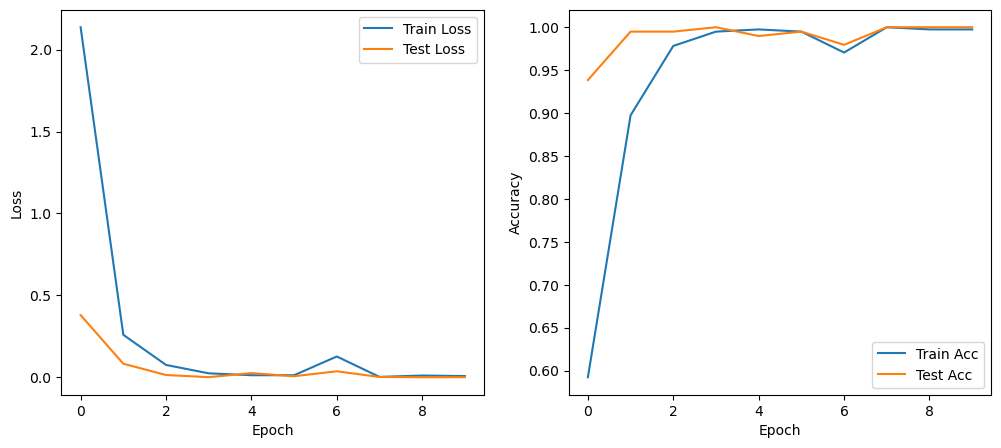

In [5]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train Acc")
plt.plot(test_acc, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [6]:
max(test_acc)

1.0

## Задание 2

Для [набора данных](https://drive.google.com/drive/folders/1sPwKGt_BX0fwGFTwVcoC7opwLT41b9Ug?usp=sharing) построить модель многоклассовой классификации, постараться улучшить точность модели. Построить графики кривых обучения.

In [2]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
data_dir = 'data/Apples'

train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomPerspective(distortion_scale=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

full_dataset = datasets.ImageFolder(data_dir)

train_dataset, test_dataset = random_split(full_dataset, [0.8, 0.2])
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

len(train_dataset), len(test_dataset)

(1781, 445)

In [ ]:
CNN = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),
    nn.Linear(512 * 8 * 8, 512),
    nn.ReLU(),
    nn.Linear(512, 4)
)

model = CNN.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [ ]:
train_losses, test_losses, train_acc, test_acc = [], [], [], []

model.train()
for epoch in range(50):
    train_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    train_losses.append(train_loss / total)
    train_acc.append(correct / total)

    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with th.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        test_losses.append(test_loss / total)
        test_acc.append(correct / total)

    print(f"Epoch {epoch+1}: Train Loss {train_losses[-1]:.4f}, Acc {train_acc[-1]:.4f} | Test Loss {test_losses[-1]:.4f}, Acc {test_acc[-1]:.4f}")

Epoch 1: Train Loss 1.3610, Acc 0.3543 | Test Loss 1.0117, Acc 0.5955
Epoch 2: Train Loss 0.8167, Acc 0.6631 | Test Loss 0.5806, Acc 0.7596
Epoch 3: Train Loss 0.4912, Acc 0.8097 | Test Loss 0.4219, Acc 0.8337
Epoch 4: Train Loss 0.3643, Acc 0.8636 | Test Loss 0.3017, Acc 0.8876
Epoch 5: Train Loss 0.2660, Acc 0.9045 | Test Loss 0.2352, Acc 0.9101
Epoch 6: Train Loss 0.2097, Acc 0.9220 | Test Loss 0.2085, Acc 0.9326
Epoch 7: Train Loss 0.2186, Acc 0.9220 | Test Loss 0.1878, Acc 0.9303
Epoch 8: Train Loss 0.2030, Acc 0.9270 | Test Loss 0.1581, Acc 0.9528
Epoch 9: Train Loss 0.1403, Acc 0.9512 | Test Loss 0.1190, Acc 0.9596
Epoch 10: Train Loss 0.0982, Acc 0.9663 | Test Loss 0.1265, Acc 0.9483
Epoch 11: Train Loss 0.1105, Acc 0.9590 | Test Loss 0.1292, Acc 0.9483
Epoch 12: Train Loss 0.0859, Acc 0.9708 | Test Loss 0.1533, Acc 0.9483
Epoch 13: Train Loss 0.0790, Acc 0.9719 | Test Loss 0.1252, Acc 0.9528
Epoch 14: Train Loss 0.0824, Acc 0.9719 | Test Loss 0.0802, Acc 0.9663
Epoch 15: Train

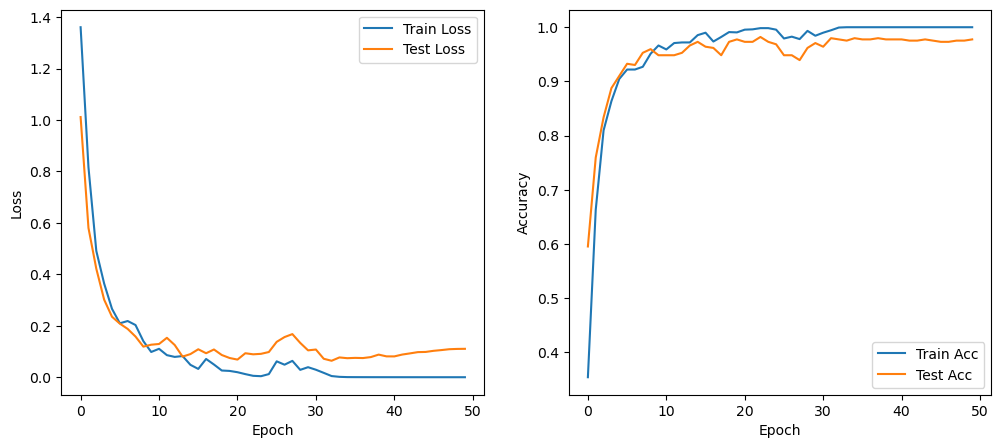

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train Acc")
plt.plot(test_acc, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [13]:
max(test_acc)

0.9820224719101124

## Задание 3

Для [набора данных](https://drive.google.com/drive/folders/1sPwKGt_BX0fwGFTwVcoC7opwLT41b9Ug?usp=sharing) изучить зависимость точности модели от количества слоев. Построить графики кривых обучения и интерпретировать.

In [2]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
data_dir = 'data/Apples'

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

full_dataset = datasets.ImageFolder(data_dir, transform=transform)
train_dataset, test_dataset = random_split(full_dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

len(train_dataset), len(test_dataset)

(1781, 445)

In [ ]:
def build_model(num_conv_layers):
    layers = []
    in_channels = 3
    out_channels = 32
    for i in range(num_conv_layers):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(2,2))
        in_channels = out_channels
        out_channels *= 2  

    layers.append(nn.Flatten())

    final_size = 256 // (2**num_conv_layers)
    fc_in = in_channels * final_size * final_size
    layers.append(nn.Linear(fc_in, 512))
    layers.append(nn.ReLU())
    layers.append(nn.Linear(512, 4))
    return nn.Sequential(*layers)

def train_model(model, epochs=30, lr=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    train_losses, test_losses = [], []
    train_acc, test_acc = [], []
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        train_losses.append(running_loss/total)
        train_acc.append(correct/total)
        
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with th.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                correct += (outputs.argmax(1) == labels).sum().item()
                total += labels.size(0)
        test_losses.append(running_loss/total)
        test_acc.append(correct/total)
        print(f"Epoch {epoch+1}: Train Loss {train_losses[-1]:.4f}, Train Acc {train_acc[-1]:.4f} | Test Loss {test_losses[-1]:.4f}, Test Acc {test_acc[-1]:.4f}")
    return {'train_losses': train_losses, 'test_losses': test_losses, 'train_acc': train_acc, 'test_acc': test_acc}

num_layers_list = [2, 3, 4, 5, 6]
results = {}
models_dict = {}

for n in num_layers_list:
    print(f"\nОбучаем модель с {n} свёрточными слоями:")
    model = build_model(n)
    models_dict[n] = copy.deepcopy(model)
    results[n] = train_model(model, epochs=30, lr=0.001)


Обучаем модель с 2 свёрточными слоями:
Epoch 1: Train Loss 11.1824, Train Acc 0.4228 | Test Loss 1.3360, Test Acc 0.5213
Epoch 2: Train Loss 1.0832, Train Acc 0.5598 | Test Loss 0.8957, Test Acc 0.5798
Epoch 3: Train Loss 0.7500, Train Acc 0.6682 | Test Loss 0.7607, Test Acc 0.6315
Epoch 4: Train Loss 0.5487, Train Acc 0.7569 | Test Loss 0.6109, Test Acc 0.7483
Epoch 5: Train Loss 0.3606, Train Acc 0.8793 | Test Loss 0.5499, Test Acc 0.8022
Epoch 6: Train Loss 0.1929, Train Acc 0.9388 | Test Loss 0.4984, Test Acc 0.8180
Epoch 7: Train Loss 0.1089, Train Acc 0.9669 | Test Loss 0.4764, Test Acc 0.8202
Epoch 8: Train Loss 0.0646, Train Acc 0.9860 | Test Loss 0.4885, Test Acc 0.8337
Epoch 9: Train Loss 0.0392, Train Acc 0.9949 | Test Loss 0.5057, Test Acc 0.8562
Epoch 10: Train Loss 0.0226, Train Acc 0.9972 | Test Loss 0.5113, Test Acc 0.8494
Epoch 11: Train Loss 0.0162, Train Acc 0.9994 | Test Loss 0.5313, Test Acc 0.8517
Epoch 12: Train Loss 0.0074, Train Acc 1.0000 | Test Loss 0.5406, 

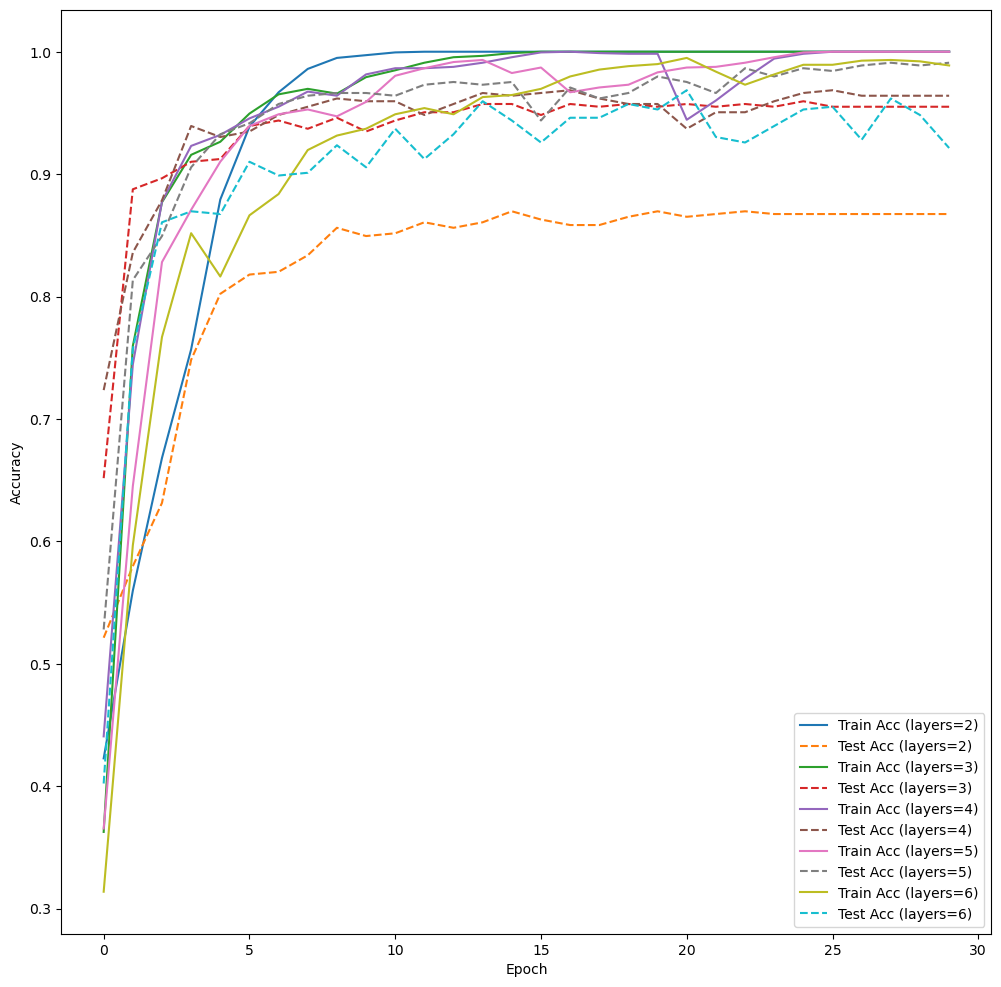

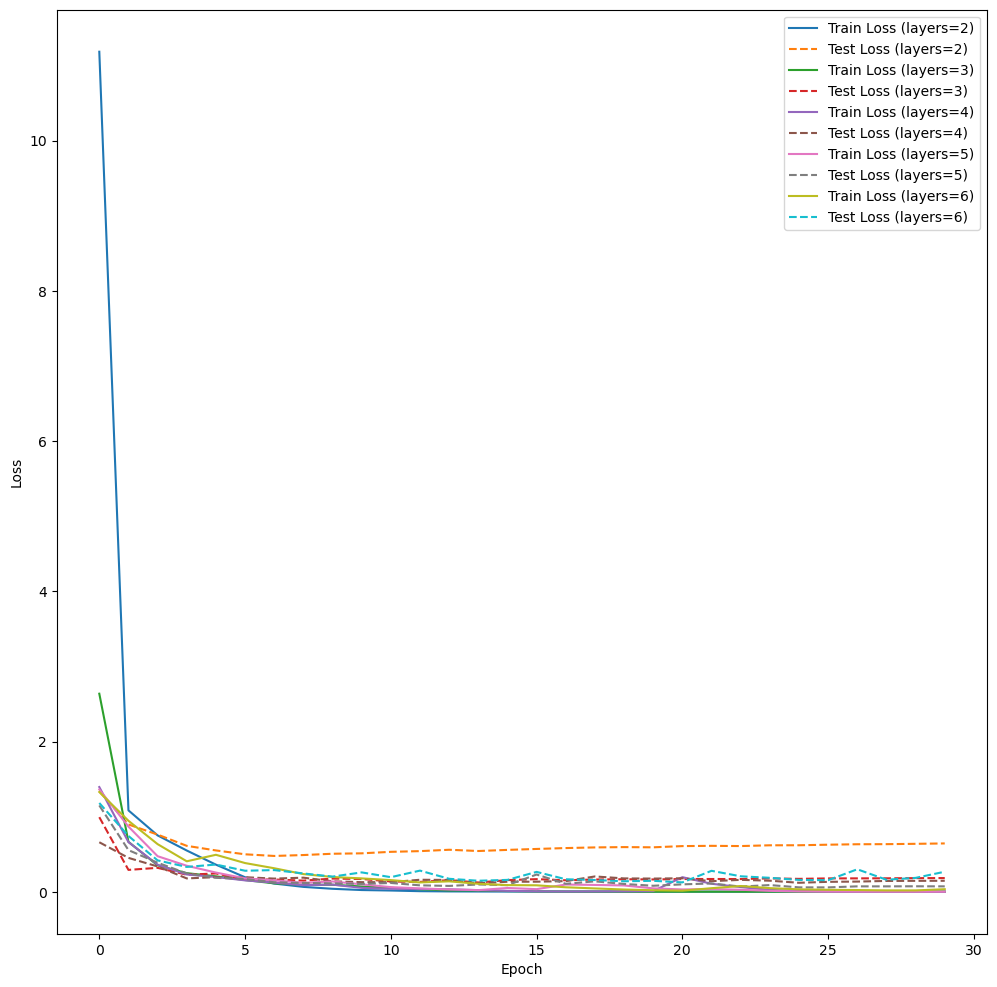

In [4]:
plt.figure(figsize=(12, 12))
for n in num_layers_list:
    plt.plot(results[n]['train_acc'], label=f"Train Acc (layers={n})")
    plt.plot(results[n]['test_acc'], '--', label=f"Test Acc (layers={n})")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12, 12))
for n in num_layers_list:
    plt.plot(results[n]['train_losses'], label=f"Train Loss (layers={n})")
    plt.plot(results[n]['test_losses'], '--', label=f"Test Loss (layers={n})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Задание 4

Для [набора данных](https://drive.google.com/drive/folders/1sPwKGt_BX0fwGFTwVcoC7opwLT41b9Ug?usp=sharing) провести обучение с переносом, используя обученную сеть (например, VGG16) Изучить влияние точности модели от количества добавляемых новых слоев. Построить графики кривых обучения для каждого случая в TensorBoard.

In [2]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
data_dir = 'data/Apples'

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

full_dataset = datasets.ImageFolder(data_dir, transform=transform)
train_dataset, test_dataset = random_split(full_dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

len(train_dataset), len(test_dataset)

(1781, 445)

In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 4)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

In [ ]:
def get_model(num_new_layers):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    in_features = model.fc.in_features
    if num_new_layers == 0:
        model.fc = nn.Linear(in_features, 4)
    else:
        layers = []
        hidden_size = 512  
        layers.append(nn.Linear(in_features, hidden_size))
        layers.append(nn.ReLU())

        for _ in range(num_new_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, 4))
        model.fc = nn.Sequential(*layers)
    return model.to(device)

def train_model(model, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=5e-5)
    train_losses, test_losses, train_acc, test_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)
        train_loss = running_loss / total
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_acc.append(train_accuracy)
        
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with th.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                correct += (outputs.argmax(dim=1) == labels).sum().item()
                total += labels.size(0)
        test_loss = running_loss / total
        test_accuracy = correct / total
        test_losses.append(test_loss)
        test_acc.append(test_accuracy)
        
        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Acc {train_accuracy:.4f} | Test Loss {test_loss:.4f}, Acc {test_accuracy:.4f}")
    
    return train_losses, train_acc, test_losses, test_acc

In [8]:
num_layers_list = [0, 1, 2, 3]
results = {}

for num_new_layers in num_layers_list:
    print(f"\nОбучаем модель с {num_new_layers} дополнительными слоями в классификаторе:")
    writer = SummaryWriter(log_dir=f"results/runs/layers_{num_new_layers}")
    
    model = get_model(num_new_layers)
    train_losses, train_acc, test_losses, test_acc = train_model(model, num_epochs=10)
    results[num_new_layers] = {
        "train_loss": train_losses,
        "train_acc": train_acc,
        "test_loss": test_losses,
        "test_acc": test_acc
    }
    
    for epoch in range(len(train_losses)):
        writer.add_scalar('Loss/Train', train_losses[epoch], epoch)
        writer.add_scalar('Loss/Val', test_losses[epoch], epoch)
        writer.add_scalar('Accuracy/Train', train_acc[epoch], epoch)
        writer.add_scalar('Accuracy/Val', test_acc[epoch], epoch)
    writer.close()


Обучаем модель с 0 дополнительными слоями в классификаторе:
Epoch 1: Train Loss 0.3285, Acc 0.8815 | Test Loss 0.0243, Acc 0.9978
Epoch 2: Train Loss 0.0259, Acc 0.9983 | Test Loss 0.0130, Acc 1.0000
Epoch 3: Train Loss 0.0091, Acc 1.0000 | Test Loss 0.0091, Acc 0.9978
Epoch 4: Train Loss 0.0071, Acc 1.0000 | Test Loss 0.0128, Acc 0.9955
Epoch 5: Train Loss 0.0076, Acc 1.0000 | Test Loss 0.0066, Acc 1.0000
Epoch 6: Train Loss 0.0032, Acc 1.0000 | Test Loss 0.0043, Acc 1.0000
Epoch 7: Train Loss 0.0021, Acc 1.0000 | Test Loss 0.0032, Acc 1.0000
Epoch 8: Train Loss 0.0025, Acc 1.0000 | Test Loss 0.0026, Acc 1.0000
Epoch 9: Train Loss 0.0028, Acc 1.0000 | Test Loss 0.0022, Acc 1.0000
Epoch 10: Train Loss 0.0014, Acc 1.0000 | Test Loss 0.0016, Acc 1.0000

Обучаем модель с 1 дополнительными слоями в классификаторе:
Epoch 1: Train Loss 0.5003, Acc 0.8624 | Test Loss 0.0440, Acc 1.0000
Epoch 2: Train Loss 0.0384, Acc 0.9961 | Test Loss 0.0162, Acc 0.9978
Epoch 3: Train Loss 0.0154, Acc 0.998

In [ ]:
!tensorboard --logdir=results/runs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.19.0 at http://localhost:6006/ (Press CTRL+C to quit)


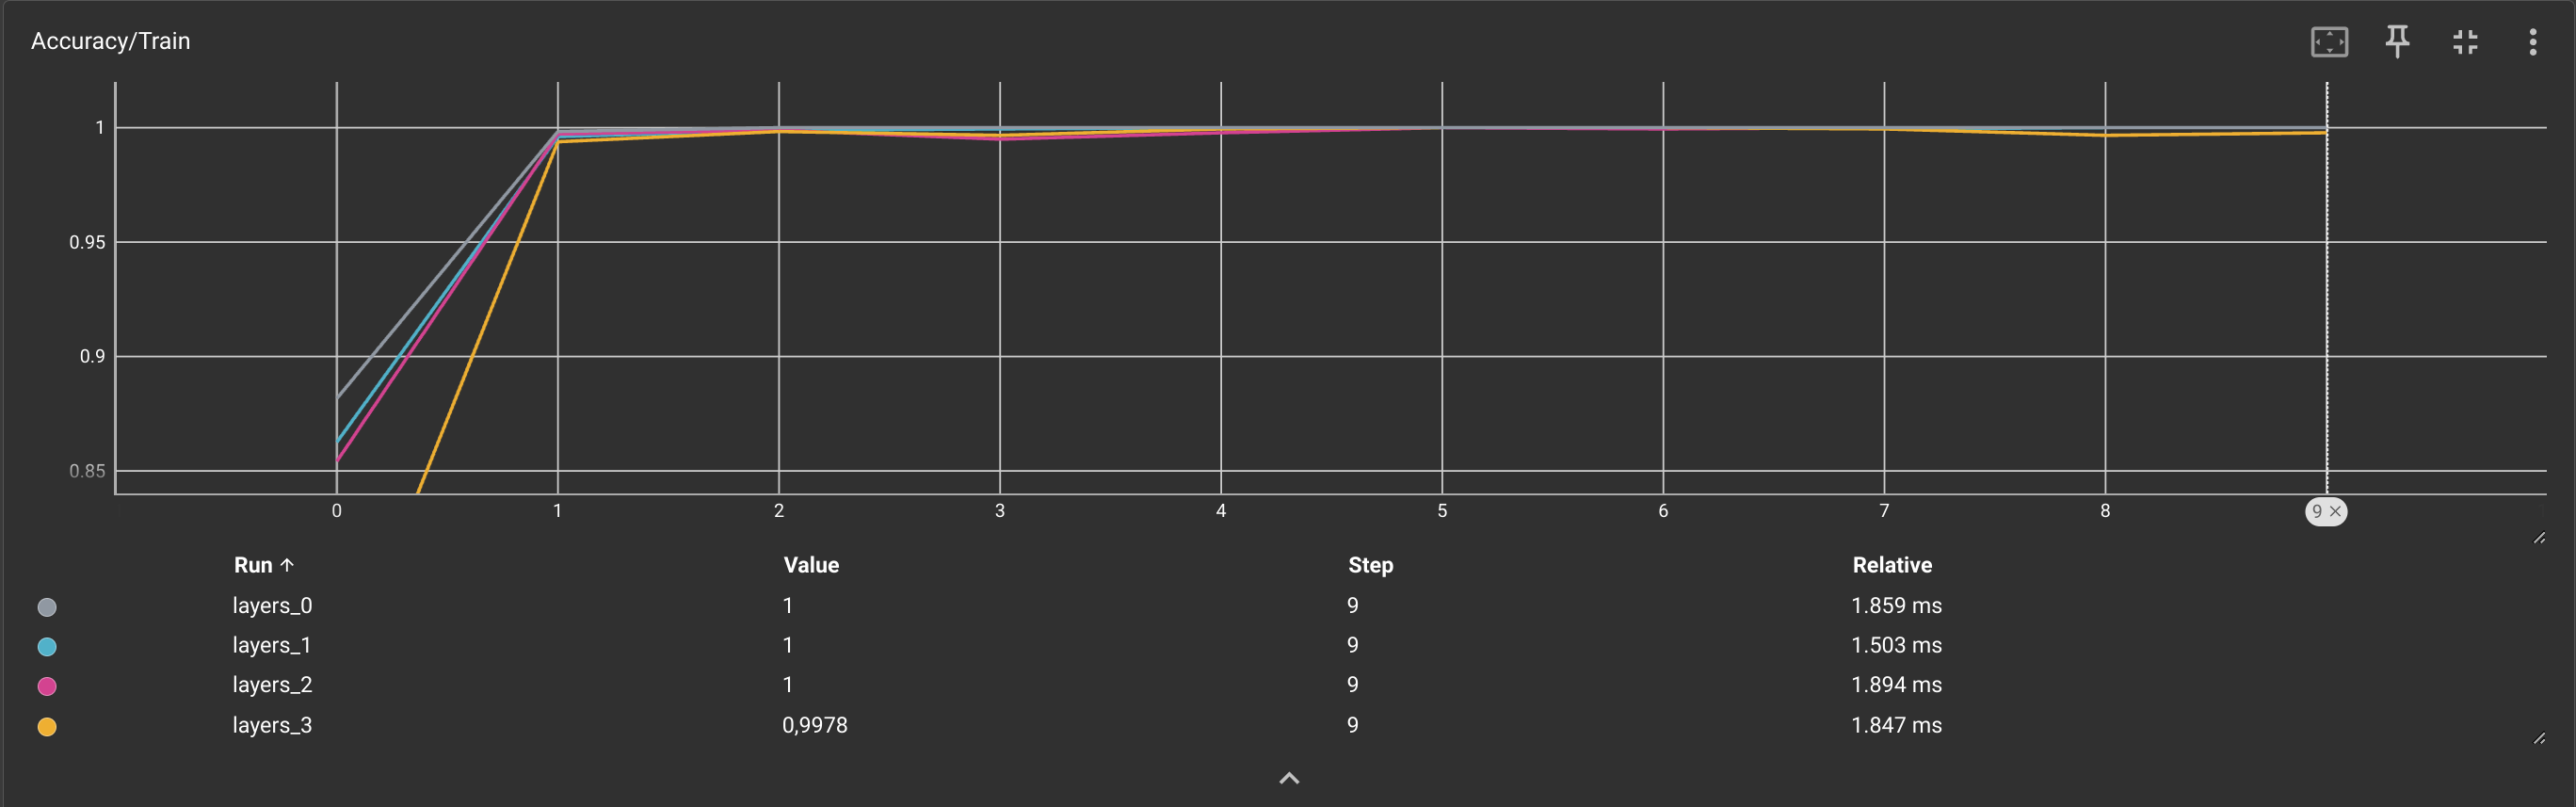
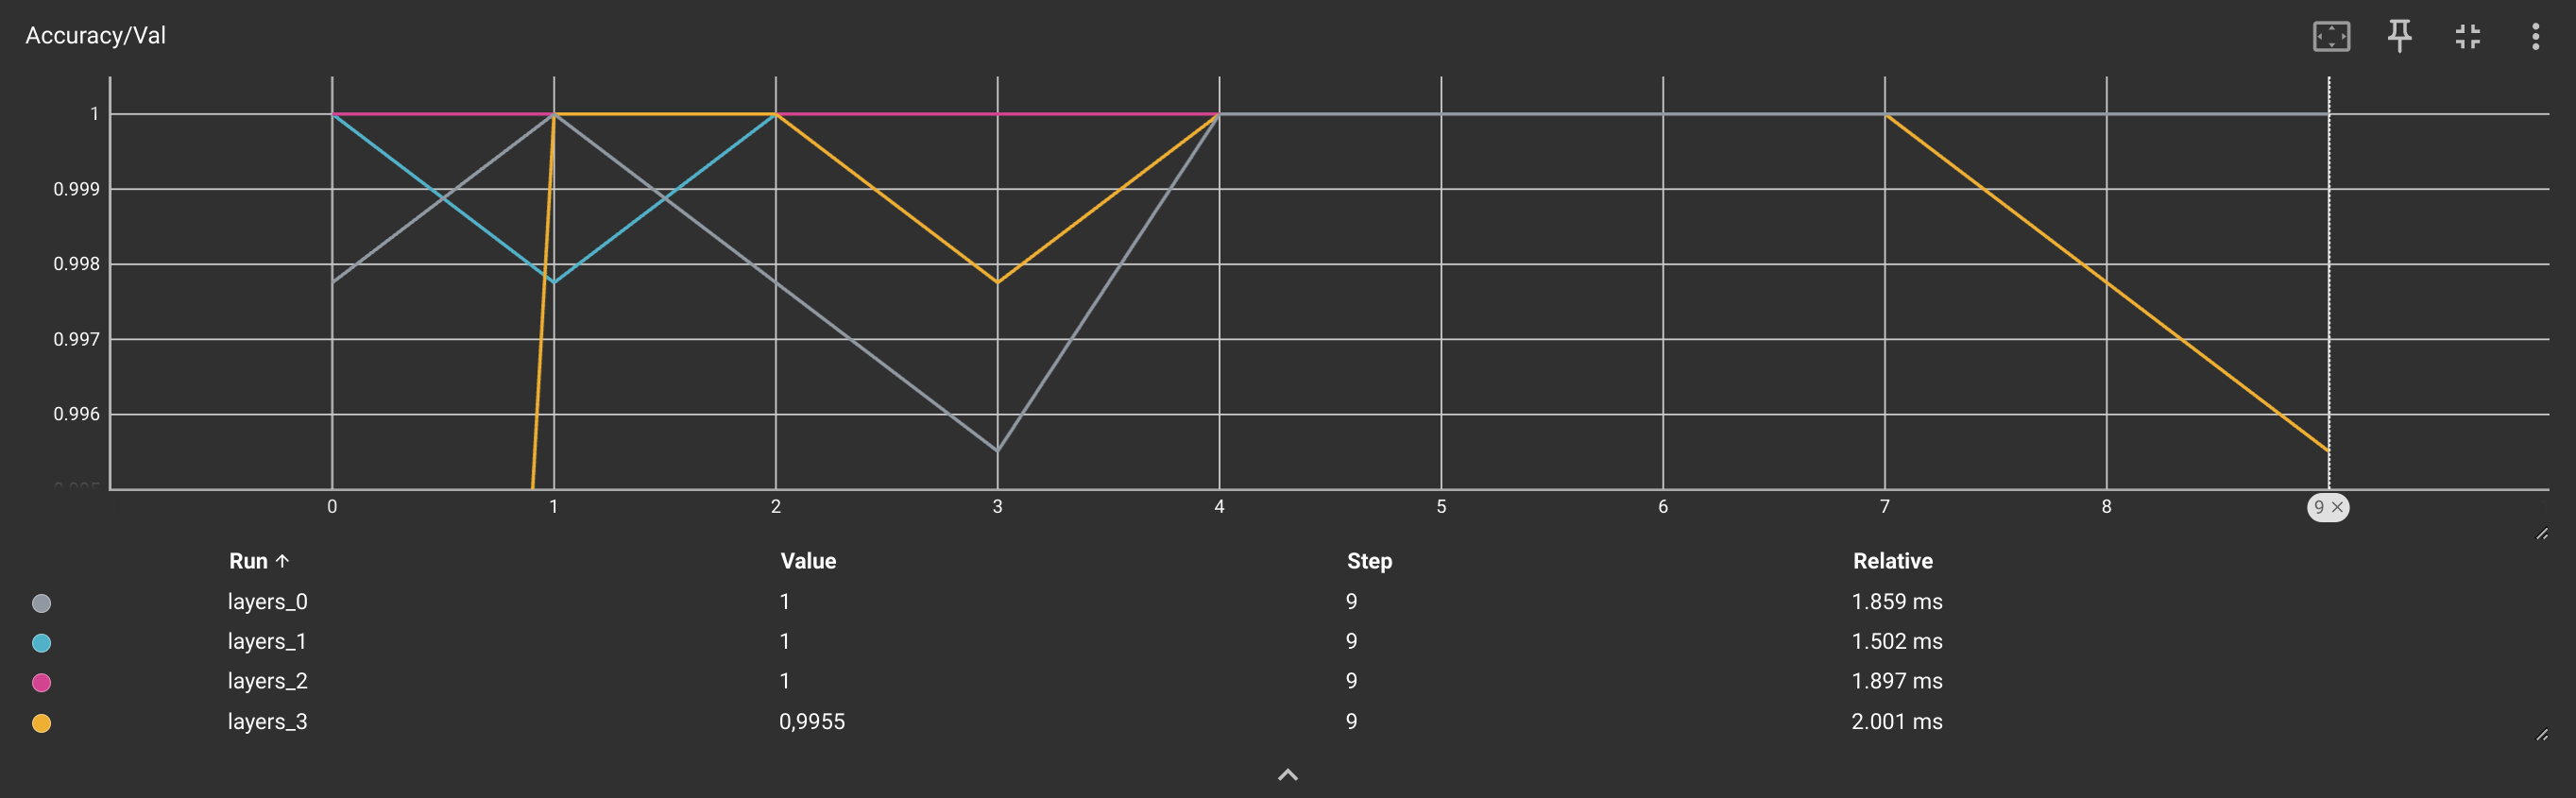
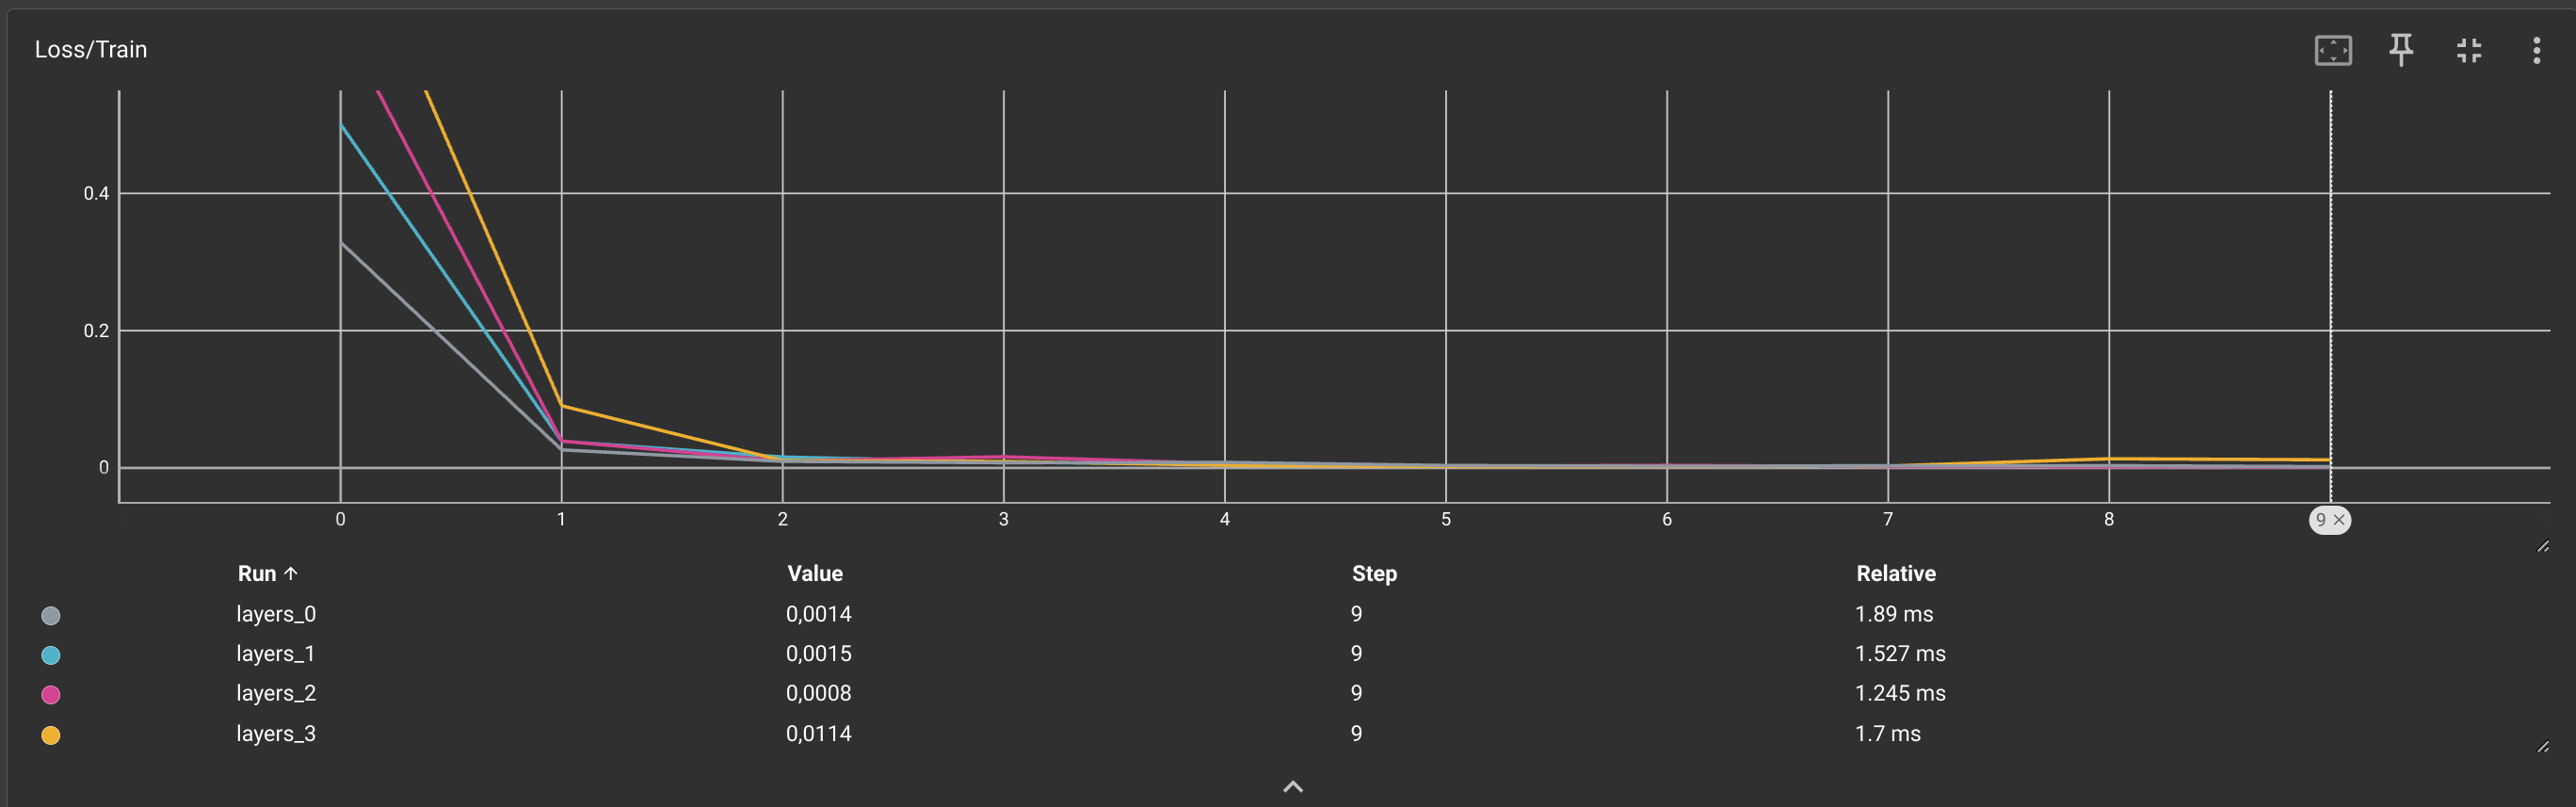
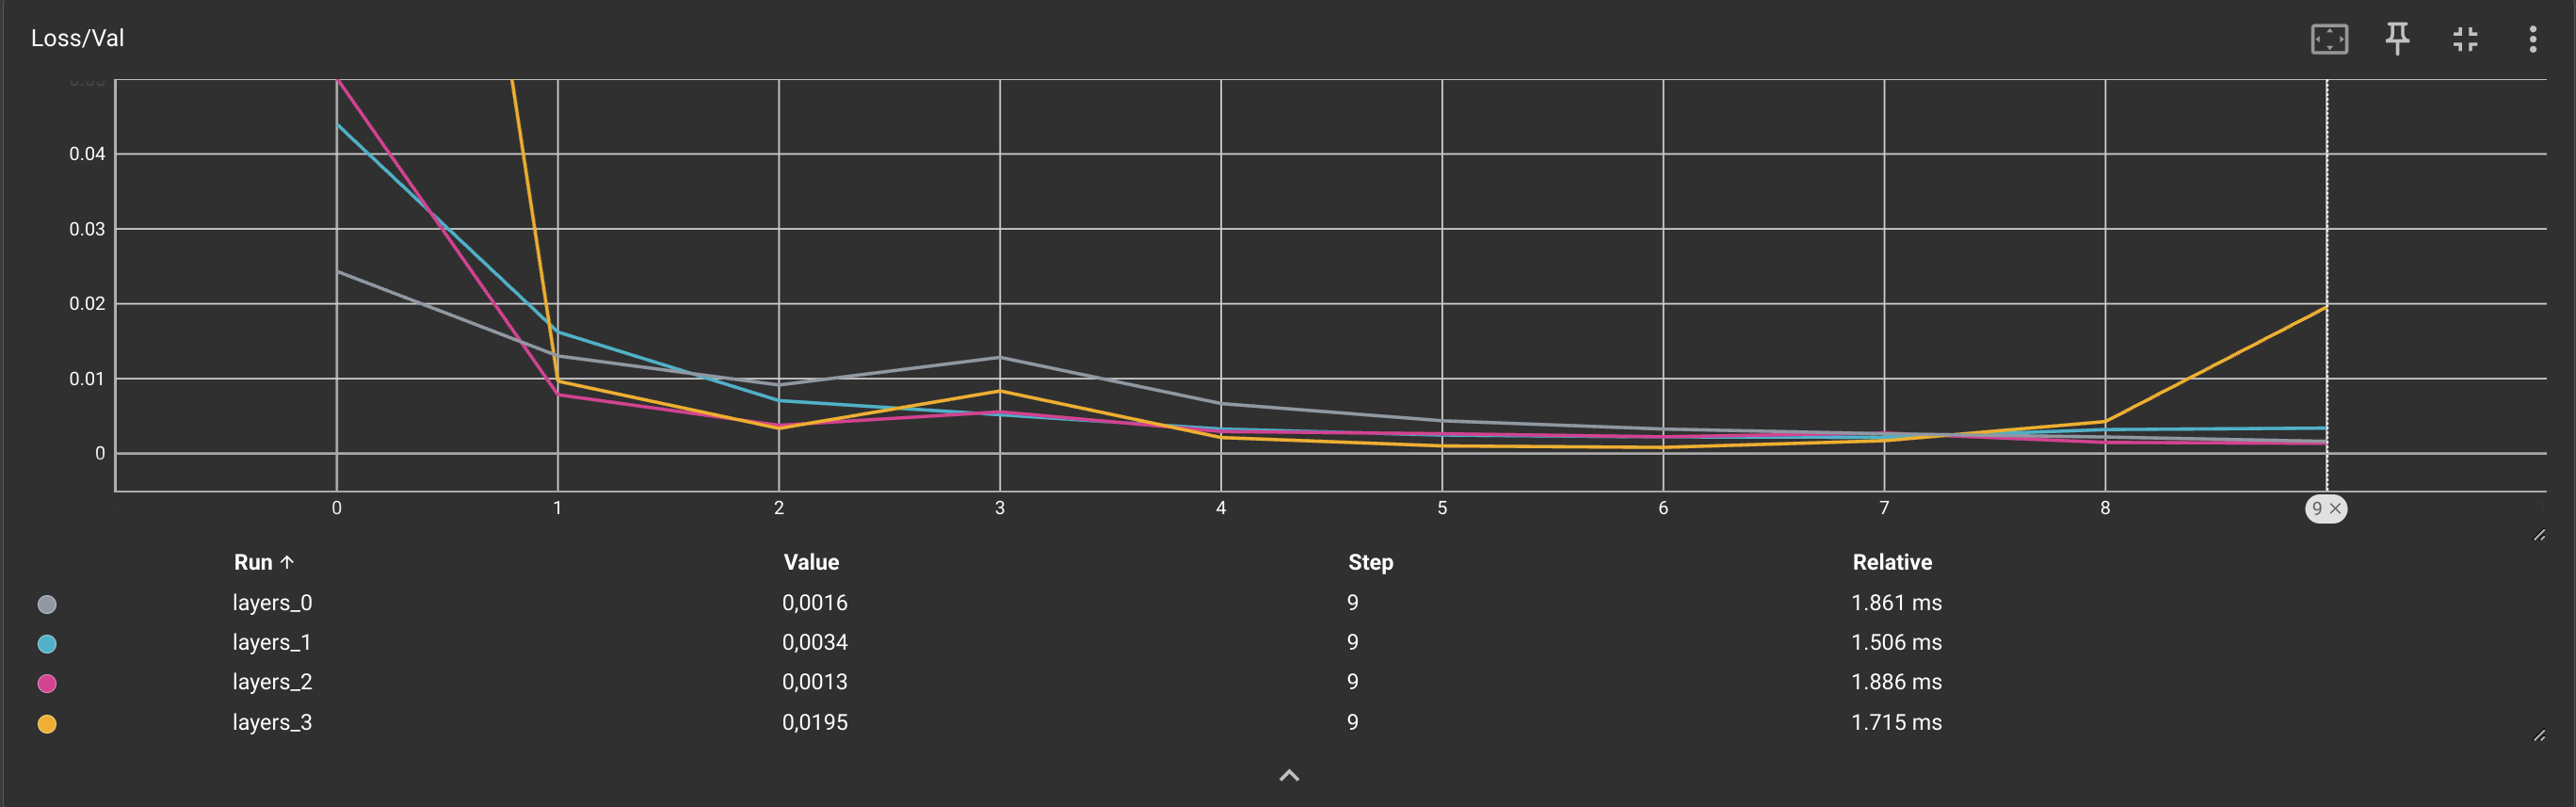